<a href="https://colab.research.google.com/github/Wangsherpa/english_to_nepali_translation/blob/main/NMT_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Machine Translation System
## English to Nepali

## Import Necessary Packages

In [91]:
import os
import time
import pickle
import unicodedata
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Embedding, Input, GRU
from tensorflow.keras.layers import TimeDistributed, RepeatVector
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

from sklearn.model_selection import train_test_split
from IPython.display import clear_output

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define paths

In [3]:
# model checkpoint paths
checkpoint_1 = "/content/drive/MyDrive/english-to-nepali-translation/Checkpoints/model_1"
checkpoint_2 = "/content/drive/MyDrive/english-to-nepali-translation/Checkpoints/model_2"
checkpoint_3 = "/content/drive/MyDrive/english-to-nepali-translation/Checkpoints/model_3"
checkpoint_4 = "/content/drive/MyDrive/english-to-nepali-translation/Checkpoints/model_4"

# paths to save predictions
prediction_dir = "/content/drive/MyDrive/english-to-nepali-translation/predictions"

### Load the data

In [4]:
# Download the data
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1pHhyR00L4Pi_ezg-p_jzVjhEMR9AoGlN' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1pHhyR00L4Pi_ezg-p_jzVjhEMR9AoGlN" -O eng_nepali.csv && rm -rf /tmp/cookies.txt
clear_output()
print("Dataset downloaded successfully!")

Dataset downloaded successfully!


In [5]:
# set datapath
datapath = "/content/eng_nepali.csv"
# load the data
dataset = pd.read_csv(datapath)
dataset.head()

,English,Nepali
0,go,जानु
1,hi,हाई
2,run,दगुर्ने काम
3,fire,आगो
4,help,सहायता


In [6]:
# check the shape of the dataframe
dataset.shape

(9886, 2)

**Preprocessing functions used for cleaning the dataset**

In [7]:
# create a dictionary for subwords
dic = {"won't":"will not", "ain't":"am not", "t": "not", "re": "are", "s": "is", "can't": "can not", 
       "ll": "will", "m": "am", "ve": "have", "let's": "let us", "d": "had"}

# function to create subwords
def get_subwords(string):
    if string in dic.keys():
        return dic[string]
    
    string = string.split("'")
    if string[-1] in dic.keys():
        last = dic[string[1]]
    else:
        last = string[-1]
    if string[-1] == 't':
        first = string[0][:-1]
    else:
        first = string[0]
    return ' '.join([first, last])

def add_subwords(sentence):
    subword_map = {}
    for word in sentence.split():
        if "'" in word:
            subwords = get_subwords(word)
            subword_map[word] = subwords
    for word, subword in subword_map.items():
        sentence = sentence.replace(word, subword)
    return sentence

# clean english sentences
def preprocess_english(sent):
    # get list of punctuations but not "'"
    punctuations = string.punctuation.replace("'", "")
    digits = string.digits
    
    remove_digits = str.maketrans('', '', digits)
    # convert to lower case
    sent = sent.lower()
    sent = "".join([c for c in sent if c not in punctuations])
    # remove numbers
    sent = sent.translate(remove_digits)
    # remove extra spaces 
    sent = sent.strip()
    # replace words like don't, we've with do not, we have...
    sent = add_subwords(sent)
    return sent

## Prepare data for English to Nepali Translation

In [8]:
# add start and end tokens
dataset['English'] = 'start_ ' + dataset.English + ' end_'
dataset['Nepali'] = 'start_ ' + dataset.Nepali + ' end_'

## Tokenize the data

In [9]:
# create a function to build tokenizer
def tokenize(sentences, vocab_size=None):
  # create a tokenizer
  tokenizer = Tokenizer(filters='', num_words=vocab_size, oov_token='UNK')
  # fit the tokenizer on sentences
  tokenizer.fit_on_texts(sentences)
  if vocab_size is None:
    # calculate vocabulary size
    vocab_size = len(tokenizer.word_index)

  # calculate max sentence length in a sentence
  max_sent_len = max([len(sentence.split()) for sentence in sentences])
  return tokenizer, vocab_size, max_sent_len

In [10]:
# english sentence tokenizer
english_tokenizer, english_vocabsize, english_maxlen = tokenize(dataset.English, vocab_size=None)

# nepali sentence tokenizer
nepali_tokenizer, nepali_vocabsize, nepali_maxlen = tokenize(dataset.Nepali, vocab_size=None)

print("English Vocab Size:", english_vocabsize)
print("Nepali Vocab Size:", nepali_vocabsize)
print("Max English Sentence Length:", english_maxlen)
print("Max Nepali Sentence Length:", nepali_maxlen)

English Vocab Size: 2825
Nepali Vocab Size: 4353
Max English Sentence Length: 8
Max Nepali Sentence Length: 11


# Split the dataset

In [11]:
# Split the data into train test and validation
X_train, X_valid, y_train, y_valid = train_test_split(dataset.English, dataset.Nepali, test_size=0.2,
                                                    random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=40)

X_train.shape, X_valid.shape, X_test.shape

((7908,), (989,), (989,))

## Convert to TensorFlow Dataset

In [12]:
# write a function to create dataset
def create_dataset(source, target, src_maxlen=english_maxlen,
                   tar_maxlen=nepali_maxlen,
                   src_tokenizer=english_tokenizer,
                   tar_tokenizer=nepali_tokenizer, teacher_forcing=False):
  # tokenize the sentences
  source = src_tokenizer.texts_to_sequences(source)
  target = tar_tokenizer.texts_to_sequences(target)
  
  if not teacher_forcing:
    # pad sequences to max length
    source_padded = pad_sequences(source, maxlen=src_maxlen, padding='post')
    target_padded = pad_sequences(target, maxlen=tar_maxlen, padding='post')

    # create tensorflow dataset
    dataset = tf.data.Dataset.from_tensor_slices((source_padded, target_padded))
    dataset = dataset.batch(32, drop_remainder=True)
    dataset = dataset.prefetch(1)
    return dataset

  # if teacher_forcing is True
  target_in = [sentence[:-1] for sentence in target] # end token excluded
  target_out = [sentence[1:] for sentence in target] # start token excluded

  # pad sequences to max length
  source_padded = pad_sequences(source, maxlen=src_maxlen, padding='post')
  target_in_padded = pad_sequences(target_in, maxlen=tar_maxlen, padding='post')
  target_out_padded = pad_sequences(target_out, maxlen=tar_maxlen, padding='post')

  # create a tensorflow datasest
  dataset = tf.data.Dataset.from_tensor_slices(((source_padded, target_in_padded), target_out_padded))
  # batch and prefetch dataset
  dataset = dataset.batch(32, drop_remainder=True)
  dataset = dataset.prefetch(1)
  return dataset

In [37]:
# create tensorflow datasets for first model
train_dataset = create_dataset(X_train, y_train)
valid_dataset = create_dataset(X_valid, y_valid)
test_dataset = create_dataset(X_test, y_test)

In [14]:
# look at the data in training set
for row in train_dataset:
  print(english_tokenizer.sequences_to_texts([row[0][0].numpy()]))
  print(nepali_tokenizer.sequences_to_texts([row[1][0].numpy()]))
  break

['start_ i like puzzles end_ UNK UNK UNK']
['start_ मलाई पजलहरू मन पर्छ end_ UNK UNK UNK UNK UNK']


## Build the model (Simple Model)

In [15]:
def build_model(src_vocab, tar_vocab, src_maxlen, tar_maxlen, n_units):
  # initialize sequential model
  src_input = Input(shape=[None])

  # embedding layer
  src_embedding = Embedding(src_vocab+1, n_units, input_length=src_maxlen, mask_zero=True)(src_input)

  # source LSTM layer
  src_lstm_out = LSTM(n_units)(src_embedding)
  # repeat vector
  rv = RepeatVector(tar_maxlen)(src_lstm_out)
  # target LSTM layer
  tar_lstm_out = LSTM(n_units, return_sequences=True)(rv)

  # output layer
  output = TimeDistributed(Dense(tar_vocab+1, activation='softmax'))(tar_lstm_out)

  model = Model(inputs=[(src_input)], outputs=[output])

  # compile the model
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [16]:
# build model
model_1 = build_model(english_vocabsize, nepali_vocabsize, english_maxlen, nepali_maxlen, 128)
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         361728    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               131584    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 11, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 11, 128)           131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 11, 4354)          561666    
Total params: 1,186,562
Trainable params: 1,186,562
Non-trainable params: 0
___________________________________________________

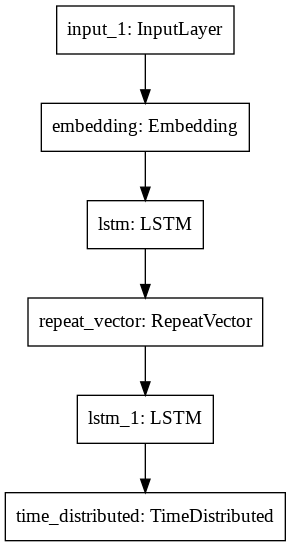

In [17]:
# plot model
plot_model(model_1)

In [18]:
# create callbacks to save model and early stop model training 
checkpoint_dir = os.path.join(checkpoint_1, "model_1.h5")
model_checkpoint = ModelCheckpoint(checkpoint_dir, monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(patience=7, monitor='val_loss', restore_best_weights=True)

history = model_1.fit(train_dataset, epochs=100, validation_data=valid_dataset,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
247/247 [==============================] - 10s 16ms/step - loss: 3.2559 - val_loss: 2.4855
Epoch 2/100
247/247 [==============================] - 3s 11ms/step - loss: 2.2561 - val_loss: 2.2170
Epoch 3/100
247/247 [==============================] - 3s 11ms/step - loss: 2.0528 - val_loss: 2.1391
Epoch 4/100
247/247 [==============================] - 3s 11ms/step - loss: 1.9635 - val_loss: 2.0969
Epoch 5/100
247/247 [==============================] - 3s 11ms/step - loss: 1.8977 - val_loss: 2.0408
Epoch 6/100
247/247 [==============================] - 3s 11ms/step - loss: 1.8426 - val_loss: 2.0071
Epoch 7/100
247/247 [==============================] - 3s 11ms/step - loss: 1.8087 - val_loss: 1.9894
Epoch 8/100
247/247 [==============================] - 2s 10ms/step - loss: 1.7672 - val_loss: 1.9749
Epoch 9/100
247/247 [==============================] - 2s 10ms/step - loss: 1.7194 - val_loss: 1.9078
Epoch 10/100
247/247 [==============================] - 2s 10ms/step - loss: 1.65

In [38]:
# evaluate on a test set
print("Test set loss: {:.4f}".format(model_1.evaluate(test_dataset, verbose=0)))

Test set loss: 1.5545


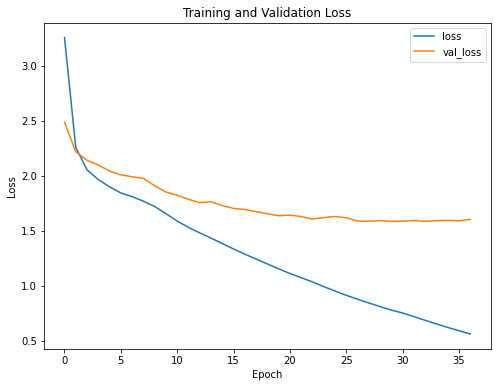

In [30]:
# plot loss and accuracy
def plot_loss(history):
  fig, ax = plt.subplots(figsize=(8, 6))
  pd.DataFrame(history.history)[["loss", "val_loss"]].plot(ax=ax)
  ax.set_title("Training and Validation Loss")
  ax.set_xlabel("Epoch")
  ax.set_ylabel("Loss")
  plt.show()

# plot model 1 losses
plot_loss(history)

In [21]:
# prepare data for translation
def prepare_data(sent):
    sent = preprocess_english(sent)
    sent_tokens = english_tokenizer.texts_to_sequences([sent])
    sent_padded = pad_sequences(sent_tokens, maxlen=english_maxlen, padding='post')
    return sent_padded

# remove start_, end_ tokens
def remove_tokens(sentence):
  # sometime predicted texts contains UNK after end_ tokens
  sentence = sentence[:sentence.find('end_')].replace('start_', '').strip()
  return sentence

# translate english to nepali
def translate(eng_sent, model):
  sent = prepare_data(eng_sent)
  preds = model.predict(sent)
  translation = nepali_tokenizer.sequences_to_texts(preds.argmax(-1))[0]
  translation = remove_tokens(translation)
  return translation

# create a dataframe
def create_df(english, nepali, predicted):
  df = pd.DataFrame()
  df['enlgish'] = english
  df['nepali'] = nepali
  df['predicted'] = predicted
  return df

In [22]:
def predict_and_save_as_dataframe(model, save_path, translate_fn, X_test=X_test, y_test=y_test):
  
  english, nepali, predicted = [], [], []
  for i, sent in enumerate(X_test.values):
    # translate english to nepali
    translation = translate_fn(sent, model)
    # remove start and end tokens
    eng = remove_tokens(sent)
    nep = remove_tokens(y_test.values[i])

    # store sentences to create a dataframe
    english.append(eng)
    nepali.append(nep)
    predicted.append(translation)

  # save results to a dataframe
  df = create_df(english, nepali, predicted)
  # save dataframe to disk
  df.to_csv(save_path, index=False)
  return df

# create a dataframe from above lists
save_path = os.path.join(prediction_dir, 'model_1_predictions.csv')
model_1_predictions = predict_and_save_as_dataframe(model=model_1, save_path=save_path,
                                                    translate_fn=translate)

In [26]:
# display some predictions
model_1_predictions.sample(5)

,enlgish,nepali,predicted
683,i mean that,मेरो मतलब त्यो हो,मलाई मेरो काम काम गर्दछ
229,he is skinny,ऊ पातलो छ,उनीसँग पहिले दु खी छ
484,nothing happened,केहि पनि थिएन,यहाँ लागि काम पर्छ
347,tom was quick,टम छिटो थियो,हामी लागि काम काम
796,i sell cars,म कारहरू बेच्छु,मलाई यो प्रयास मन पर्छ


## With Teacher Forcing Method

### Build the Model

In [27]:
# define embedding size
src_embed = 256
target_embed = 256
units = 256

# define inputs
encoder_inputs = Input(shape=[None], dtype=tf.int32)
decoder_inputs = Input(shape=[None], dtype=tf.int32)

# encoder embeddings
encoder_embeddings = Embedding(english_vocabsize+1, src_embed, mask_zero=True)(encoder_inputs)
# define encoder lstm layers
encoder_lstm_layer1 = LSTM(units, return_sequences=True, dropout=0.4)
encoder_lstm_layer2 = LSTM(units, return_state=True, dropout=0.4)
# get encoder states
layer1_out = encoder_lstm_layer1(encoder_embeddings)
_, en_state_h, en_state_c = encoder_lstm_layer2(layer1_out)
encoder_states = [en_state_h, en_state_c]

# Decoder embeddings
decoder_embeddings = Embedding(nepali_vocabsize+1, target_embed, mask_zero=True)(decoder_inputs)
decoder_lstm_layer = LSTM(units, return_sequences=True)
decoder_lstm_output = decoder_lstm_layer(decoder_embeddings, initial_state=encoder_states)
# get decoder final output
decoder_output = Dense(nepali_vocabsize+1, activation="softmax")(decoder_lstm_output)

# Create a model
model_2 = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[decoder_output])

# compile model
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
# display model summary
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    723456      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 256)    525312      embedding_1[0][0]                
____________________________________________________________________________________________

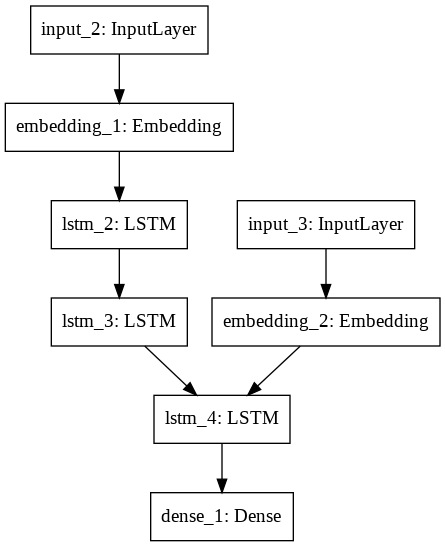

In [28]:
# plot model
plot_model(model_2)

In [53]:
# create tensorflow datasets for model which uses teacher forcing method
train_dataset = create_dataset(X_train, y_train, teacher_forcing=True)
valid_dataset = create_dataset(X_valid, y_valid, teacher_forcing=True)
test_dataset = create_dataset(X_test, y_test, teacher_forcing=True)

In [31]:
# set checkpoint path
checkpoint_dir = os.path.join(checkpoint_2, 'model_2.h5')
model_checkpoint = ModelCheckpoint(checkpoint_dir, monitor='val_loss', save_best_only=True)
early_stopping = EarlyStopping(patience=7, monitor='val_loss', restore_best_weights=True)

# train model
history = model_2.fit(train_dataset, epochs=100, validation_data=valid_dataset,
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
247/247 [==============================] - 16s 39ms/step - loss: 1.9835 - val_loss: 1.8046
Epoch 2/100
247/247 [==============================] - 7s 29ms/step - loss: 1.6641 - val_loss: 1.7124
Epoch 3/100
247/247 [==============================] - 7s 28ms/step - loss: 1.5269 - val_loss: 1.6390
Epoch 4/100
247/247 [==============================] - 7s 28ms/step - loss: 1.4080 - val_loss: 1.5688
Epoch 5/100
247/247 [==============================] - 7s 28ms/step - loss: 1.2939 - val_loss: 1.5239
Epoch 6/100
247/247 [==============================] - 7s 27ms/step - loss: 1.1952 - val_loss: 1.4861
Epoch 7/100
247/247 [==============================] - 7s 28ms/step - loss: 1.1046 - val_loss: 1.4641
Epoch 8/100
247/247 [==============================] - 7s 29ms/step - loss: 1.0242 - val_loss: 1.4445
Epoch 9/100
247/247 [==============================] - 7s 29ms/step - loss: 0.9533 - val_loss: 1.4354
Epoch 10/100
247/247 [==============================] - 7s 29ms/step - loss: 0.88

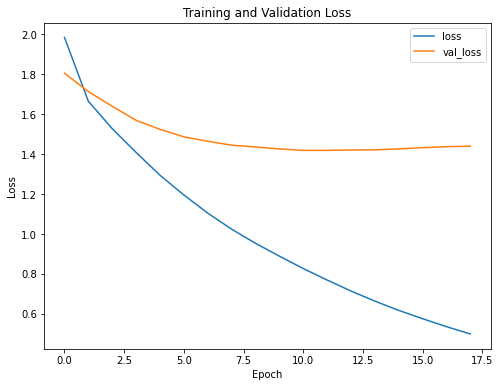

In [32]:
# plot loss
plot_loss(history)

In [35]:
# evaluate model on a test set
print("Test set loss: {:.4f}".format(model_2.evaluate(test_dataset, verbose=0)))

Test set loss: 1.4082


In [39]:
def prepare_data(sent):
    sent = preprocess_english(sent)
    sent_tokens = english_tokenizer.texts_to_sequences([sent])
    sent_padded = pad_sequences(sent_tokens, maxlen=english_maxlen, padding='post')
    return sent_padded
    
# write a function which returns the translated text in nepali
def translate(eng_sent, model):
    
    # prepare y_pred
    Y_pred = tf.fill(dims=(1, 1), value=1)
    # prepare encoder input
    X_encoder = prepare_data(eng_sent)
    
    index = 0
    next_ = 0
    end_token_id = nepali_tokenizer.texts_to_sequences(['end_'])[0][0]
    # loop until max target length or until end token is predicted
    while index < nepali_maxlen and next_ != end_token_id:
        # calculate the padding size
        padsize = nepali_maxlen - Y_pred.shape[1]
        # create input for decoder
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, padsize]])
        # get the probabilities of next prediction
        Y_proba = model.predict([X_encoder, X_decoder])[:, index:index+1]
        # get the next predicted token
        Y_proba_next = tf.argmax(Y_proba, axis=-1, output_type=tf.int32)
        # concatenate with Y_pred to predict next word
        Y_pred = tf.concat([Y_pred, Y_proba_next], axis=1)
        # assign current predicted token to next
        next_ = Y_proba_next.numpy()[0][0]
        # increment the index value
        index += 1
    # translate the sentences and return all except start and end tokens
    translated_sent = nepali_tokenizer.sequences_to_texts(Y_pred.numpy())
    return " ".join(translated_sent[0].split()[1:-1])

In [46]:
# save predictions as a dataframe
save_path = os.path.join(prediction_dir, 'model_2_predictions.csv')
model_2_predictions = predict_and_save_as_dataframe(model=model_2, save_path=save_path,
                                                    translate_fn=translate)
model_2_predictions.sample(5)

,enlgish,nepali,predicted
12,tom is guilty,टम दोषी छ,टम एक खी छ
266,this is life,यो जिवन हो,यो राम्रो छ
57,did tom go,टोम गए,टम छोड्नुहोस्
33,hold your breath,सास रोक,एक मिनेट दिनुहोस्
908,he fell backward,ऊ पछिल्तिर खसे,ऊ टम मन पर्दैन


## Seq-to-Seq Model with Pretrained-embedding

In [47]:
# download glove embedding
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Yf1XvZ3pgvNzXqnQZLHxjTunNqJIPtjJ' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Yf1XvZ3pgvNzXqnQZLHxjTunNqJIPtjJ" -O glove_embedding_50k.txt && rm -rf /tmp/cookies.txt
clear_output()


In [48]:
# load glove word embedding file
glove_emb = open('glove_embedding_50k.txt')
# initialize a dictionary to store embeddings
glove_embedding_dict = {}
# loop over all the embeddings in glove_emb
for line in glove_emb:
    # get the word
    word = line.split()[0]
    # get the embedding for the word and store in a dict
    glove_embedding_dict[word] = np.array(line.split()[1:])

# close the file
glove_emb.close()
    
# verify
glove_embedding_dict['the']

array(['0.418', '0.24968', '-0.41242', '0.1217', '0.34527', '-0.044457',
       '-0.49688', '-0.17862', '-0.00066023', '-0.6566', '0.27843',
       '-0.14767', '-0.55677', '0.14658', '-0.0095095', '0.011658',
       '0.10204', '-0.12792', '-0.8443', '-0.12181', '-0.016801',
       '-0.33279', '-0.1552', '-0.23131', '-0.19181', '-1.8823',
       '-0.76746', '0.099051', '-0.42125', '-0.19526', '4.0071',
       '-0.18594', '-0.52287', '-0.31681', '0.00059213', '0.0074449',
       '0.17778', '-0.15897', '0.012041', '-0.054223', '-0.29871',
       '-0.15749', '-0.34758', '-0.045637', '-0.44251', '0.18785',
       '0.0027849', '-0.18411', '-0.11514', '-0.78581'], dtype='<U11')

In [49]:
# Now we have to extract the embedding for the words that are in the vocabulary

# create a helper function for creating embedding matrix
def create_embedding_matrix(glove_emb, vocab_size):
    vocab_words = list(english_tokenizer.word_index.keys())
    # initialize a matrix with shape (vocab_size, 50)
    matrix = np.zeros((vocab_size+1, 50))
    # loop over the vocab words
    for word in vocab_words:
        if word in glove_emb:
            matrix[english_tokenizer.texts_to_sequences([word])[0][0]] = glove_emb[word]
    # return the updated matrix
    return matrix

In [50]:
# create embedding_matrix
embedding_matrix = create_embedding_matrix(glove_embedding_dict, english_vocabsize)
embedding_matrix.shape

(2826, 50)

In [51]:
# define embedding size
src_embed = 50
target_embed = 128
units = 256

# define inputs
encoder_inputs = Input(shape=[None], dtype=tf.int32)
decoder_inputs = Input(shape=[None], dtype=tf.int32)

# encoder embeddings
encoder_embeddings = Embedding(english_vocabsize+1, src_embed, mask_zero=True)(encoder_inputs)
# define encoder lstm layers
encoder_lstm_layer1 = LSTM(units, return_sequences=True, dropout=0.4)
encoder_lstm_layer2 = LSTM(units, return_state=True, dropout=0.4)
# get encoder states
layer1_out = encoder_lstm_layer1(encoder_embeddings)
_, en_state_h, en_state_c = encoder_lstm_layer2(layer1_out)
encoder_states = [en_state_h, en_state_c]

# Decoder embeddings
decoder_embeddings = Embedding(nepali_vocabsize+1, target_embed, mask_zero=True)(decoder_inputs)
decoder_lstm_layer = LSTM(units, return_sequences=True)
decoder_lstm_output = decoder_lstm_layer(decoder_embeddings, initial_state=encoder_states)
# get decoder final output
decoder_output = Dense(nepali_vocabsize+1, activation="softmax")(decoder_lstm_output)

# Create a model
model_emb = Model(inputs=[encoder_inputs, decoder_inputs], outputs=[decoder_output])
# Initialize embedding layer
model_emb.layers[1].set_weights([embedding_matrix])
# also do not train this layer
model_emb.layers[1].trainable = False
# display model summary
model_emb.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 50)     141300      input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, None, 256)    314368      embedding_3[0][0]                
____________________________________________________________________________________________

## Train the Model

In [54]:
# checkpoint model
save_path = os.path.join(checkpoint_3, "model_3.h5")
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(save_path, save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)
# define optimizer
optimizer = tf.keras.optimizers.Adam()
# compile model
model_emb.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

# fit the model
history = model_emb.fit(train_dataset, epochs=200, batch_size=64, validation_data=valid_dataset, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/200
247/247 [==============================] - 12s 25ms/step - loss: 1.9755 - val_loss: 1.8263
Epoch 2/200
247/247 [==============================] - 4s 15ms/step - loss: 1.6792 - val_loss: 1.6991
Epoch 3/200
247/247 [==============================] - 4s 16ms/step - loss: 1.5090 - val_loss: 1.5976
Epoch 4/200
247/247 [==============================] - 4s 17ms/step - loss: 1.3853 - val_loss: 1.5424
Epoch 5/200
247/247 [==============================] - 4s 15ms/step - loss: 1.2829 - val_loss: 1.4887
Epoch 6/200
247/247 [==============================] - 4s 16ms/step - loss: 1.1824 - val_loss: 1.4437
Epoch 7/200
247/247 [==============================] - 4s 16ms/step - loss: 1.0941 - val_loss: 1.4170
Epoch 8/200
247/247 [==============================] - 4s 17ms/step - loss: 1.0152 - val_loss: 1.3969
Epoch 9/200
247/247 [==============================] - 4s 17ms/step - loss: 0.9446 - val_loss: 1.3761
Epoch 10/200
247/247 [==============================] - 4s 18ms/step - loss: 0.87

### Plot Loss

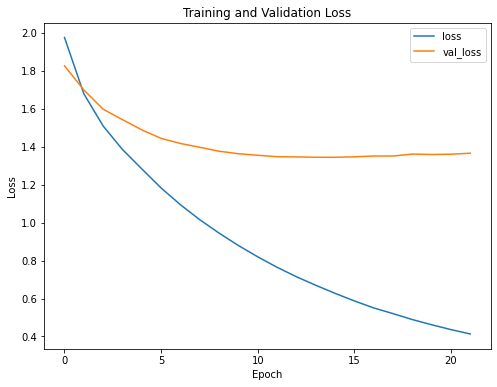

In [55]:
# plot loss
plot_loss(history)

## Evaluate on a Test set

In [56]:
loss = model_emb.evaluate(test_dataset, verbose=0)
print("{:25s}".format("Performance on Test Set"))
print("Loss: {:.4f}".format(loss))

Performance on Test Set  
Loss: 1.3428


In [65]:
# save predictions as a dataframe
save_path = os.path.join(prediction_dir, 'model_3_predictions.csv')
model_3_predictions = predict_and_save_as_dataframe(model=model_emb, save_path=save_path,
                                                    translate_fn=translate)
model_3_predictions.sample(5)

,enlgish,nepali,predicted
287,sit down tom,टम राख्नुहोस्,यहाँ टम छोड्नुहोस्
56,here they come,यहाँ तिनीहरू आउँछन्,यहाँ यहाँ जाऊ
319,look at that,त्यो हेर,यहाँ यहाँ यहाँ रहनुहोस्
424,tom hung up on me,टम मलाई झुण्ड्याइयो,टम एक नाक उडायो
539,do you watch tv,के तपाई टिभी हेर्नुहुन्छ,के तपाई उसलाई खेल्न सक्नुहुन्छ


## Attention-Based Model

### Encoder

In [66]:
embedding_dim = 256
units = 256
BATCH_SIZE = 32
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_valid.shape[0] // BATCH_SIZE

In [67]:
class Encoder(keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units,
                batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.embedding = Embedding(vocab_size+1, embedding_dim)
        self.gru = GRU(self.enc_units,
                       return_sequences=True,
                       return_state=True,
                       recurrent_initializer="glorot_uniform")
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.enc_units))
    
encoder = Encoder(english_vocabsize, embedding_dim, units, BATCH_SIZE)
# encoder.layers

### Attention

In [68]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = keras.layers.Dense(units)
        self.W2 = keras.layers.Dense(units)
        self.V = keras.layers.Dense(1)
        
    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

### Decoder

In [69]:
class Decoder(keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units,
                 batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.embedding = Embedding(vocab_size+1, embedding_dim)
        self.gru = GRU(dec_units,
                       return_sequences=True,
                       return_state=True,
                       recurrent_initializer="glorot_uniform")
        self.fc = keras.layers.Dense(vocab_size+1)
        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden,
                                                           enc_output)
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return x, state, attention_weights
    
decoder = Decoder(nepali_vocabsize, embedding_dim, units, BATCH_SIZE)


### Define Optimizer and the Loss Function

In [70]:
optimizer = keras.optimizers.Adam()
loss_object = keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                         reduction='none')

def loss_function(y_true, y_pred):
    # mask = tf.math.logical_not(tf.math.equal(true, 0))
    loss_ = loss_object(y_true, y_pred)
    mask = tf.cast(y_true != 0, tf.float32)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [71]:
# Create checkpoints
checkpoint_prefix = os.path.join(checkpoint_4, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training the Model

In [72]:
# create a dataset comaptible with Attention Model
train_dataset = create_dataset(X_train, y_train)
valid_dataset = create_dataset(X_valid, y_valid)
test_dataset = create_dataset(X_test, y_test)

In [73]:
for row in train_dataset:
  print(english_tokenizer.sequences_to_texts([row[0][0, :].numpy()]))
  # print(nepali_tokenizer.sequences_to_texts([row[0][1][0, :].numpy()]))
  print(nepali_tokenizer.sequences_to_texts([row[1][0, :].numpy()]))
  break

['start_ i like puzzles end_ UNK UNK UNK']
['start_ मलाई पजलहरू मन पर्छ end_ UNK UNK UNK UNK UNK']


In [74]:
@tf.function
def train_step(inp, targ, enc_hidden, test=False):
    loss = 0
    val_loss = 0
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        dec_input = tf.expand_dims([english_tokenizer.word_index['start_']]*BATCH_SIZE, 1)
        
        if test:
          # teacher forcing method
          for i in range(1, targ.shape[1]):
              predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
              val_loss += loss_function(targ[:, i], predictions)
              predicted_tokens = tf.argmax(predictions, axis=-1)
              dec_input = tf.expand_dims(predicted_tokens, 1)
              return val_loss / targ.shape[0]


        # teacher forcing method
        for i in range(1, targ.shape[1]):
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, i], predictions)
            dec_input = tf.expand_dims(targ[:, i], 1)
            
        batch_loss = (loss / int(targ.shape[0]))
        variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss


In [76]:
# train for 30 epochs
EPOCHS = 30
training_loss, validation_loss = [], []
# initialize previous validation loss to a large value
prev_val_loss = np.inf

# loop over number of epochs
for epoch in range(EPOCHS):
    start = time.time()
    # initialize encoder's hidden state
    enc_hidden = encoder.initialize_hidden_state()
    # initialize total training loss
    total_loss = 0
    # initialize total validation loss
    total_val_loss = 0

    # loop over all training batches
    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
        # calculate batch loss
        batch_loss = train_step(inp, targ, enc_hidden)
        # update total loss
        total_loss += batch_loss
        # print loss after every 100 batches
        if batch % 100 == 0:
            print("Epoch {} Batch {} Loss {:.4f}".format(epoch+1,
                                                         batch,
                                                         batch_loss.numpy()))
    
    # loop over all validation batches
    for (batch, (inp, targ)) in enumerate(valid_dataset.take(val_steps_per_epoch)):
      val_loss = train_step(inp, targ, enc_hidden, test=True)
      total_val_loss += val_loss

    # save model every five epochs
    if (epoch+1 % 5 == 0):
      checkpoint.save(file_prefix=checkpoint_prefix)

    # calculate current validation loss
    current_val_loss = total_val_loss / val_steps_per_epoch
    
    # save model if validation_loss improves
    if current_val_loss < prev_val_loss:
      print("[INFO] Validation loss improved from {} to {}, saving model weights...".format(prev_val_loss, 
                                                                   current_val_loss))
      checkpoint.save(file_prefix=checkpoint_prefix)
      # update previous validation loss
      prev_val_loss = current_val_loss
    
    # Display training status
    print("Epoch {} [Training Loss] : {:.4f}".format(epoch+1,
                                        total_loss / steps_per_epoch))
    print("Epoch {} [Validation Loss] : {:.4f}".format(epoch+1,
                                        total_val_loss / val_steps_per_epoch))
    print("Time taken for 1 epoch {} sec\n".format(time.time() - start))

    # store training loss
    training_loss.append(total_loss / steps_per_epoch)
    # store validation loss
    validation_loss.append(total_val_loss / val_steps_per_epoch)

Epoch 1 Batch 0 Loss 1.1620
Epoch 1 Batch 100 Loss 0.6708
Epoch 1 Batch 200 Loss 0.6125
[INFO] Validation loss improved from inf to 0.12866294384002686, saving model weights...
Epoch 1 [Training Loss] : 0.7015
Epoch 1 [Validation Loss] : 0.1287
Time taken for 1 epoch 20.743913650512695 sec

Epoch 2 Batch 0 Loss 0.6049
Epoch 2 Batch 100 Loss 0.5623
Epoch 2 Batch 200 Loss 0.5479
[INFO] Validation loss improved from 0.12866294384002686 to 0.10828609019517899, saving model weights...
Epoch 2 [Training Loss] : 0.5713
Epoch 2 [Validation Loss] : 0.1083
Time taken for 1 epoch 8.622982263565063 sec

Epoch 3 Batch 0 Loss 0.5320
Epoch 3 Batch 100 Loss 0.5049
Epoch 3 Batch 200 Loss 0.4967
[INFO] Validation loss improved from 0.10828609019517899 to 0.08974621444940567, saving model weights...
Epoch 3 [Training Loss] : 0.5123
Epoch 3 [Validation Loss] : 0.0897
Time taken for 1 epoch 9.110194444656372 sec

Epoch 4 Batch 0 Loss 0.4649
Epoch 4 Batch 100 Loss 0.4500
Epoch 4 Batch 200 Loss 0.4507
[INFO]

In [77]:
# Calculate test loss
total_test_loss = 0
for (batch, (inp, targ)) in enumerate(test_dataset.take(val_steps_per_epoch)):
      test_loss = train_step(inp, targ, enc_hidden, test=True)
      total_test_loss += test_loss

print("Test Loss: {:.4f}".format((total_test_loss/val_steps_per_epoch).numpy()))

Test Loss: 0.0839


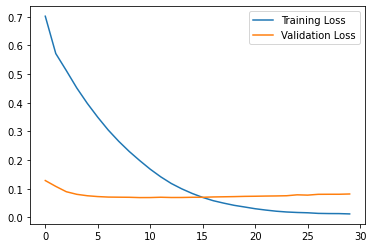

In [78]:
# plot training and validation loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.legend()
plt.show()

In [79]:
def evaluate(sentence):
    attention_plot = np.zeros((nepali_maxlen, english_maxlen))
    inputs = [english_tokenizer.texts_to_sequences([i])[0][0] for i in sentence.split()]
    inputs = pad_sequences([inputs], maxlen=english_maxlen, padding="post")
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    hidden = [tf.zeros((1, units))]
    enc_output, enc_hidden = encoder(inputs, hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([nepali_tokenizer.word_index['start_']], 0)
    for i in range(nepali_maxlen):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden,
                                                              enc_output)
        predicted_id = tf.argmax(predictions[0]).numpy()
        if nepali_tokenizer.index_word[predicted_id] == 'end_':
            return result, sentence
        result += nepali_tokenizer.index_word[predicted_id] + ' '
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence

In [80]:
def translate(sentence):
    result, sentence = evaluate(sentence)
    # print("Input: {}".format(sentence))
    # print("Translated {}".format(result))
    return result

In [81]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
# list of sentences to translate
english_test = list(X_test.values)
# original translation
nepali_test = list(y_test.values)

# initialize a list to store model translation
translations = []

# loop over all english sentences
for sent in english_test:
  translation = translate(sent)
  translations.append(translation)

# create a dataframe
prediction_df = pd.DataFrame()
prediction_df['english'] = english_test
prediction_df['nepali'] = nepali_test
prediction_df['predicted'] = translations

# remove start and end tokens
prediction_df['english'] = prediction_df.english.str.strip('start_')
prediction_df['english'] = prediction_df.english.str.strip('end_')

prediction_df['nepali'] = prediction_df.nepali.str.strip('start_')
prediction_df['nepali'] = prediction_df.nepali.str.strip('end_')

In [87]:
prediction_df.sample(5)

,english,nepali,predicted
937,i am lefthanded,म बाँचेको छु,म ठट्टामा छु
377,this book is mine,यो पुस्तक मेरो हो,यो पुस्तक मेरो हो
754,i can swim,म पौडी खेल्न सक्छु,म पौडिन सक्छु
540,i have been shot,मलाई गोली लागेको छ,मा शट
640,i miss tom,म टम सम्झन्छु,म टम घृणा गर्छु


In [105]:
# save predictions to a disk
save_path = os.path.join(prediction_dir, 'model_4_predictions.csv')
prediction_df.to_csv(save_path, index=False)

# Results
### Evaluated using BLEU Score

**Bilingual Evaluation Understudy Score**

The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.

A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

The score was developed for evaluating the predictions made by automatic machine translation systems. It is not perfect, but does offer 5 compelling benefits:

- It is quick and inexpensive to calculate.
- It is easy to understand.
- It is language independent.
- It correlates highly with human evaluation.
- It has been widely adopted.


In [106]:
# load the predicitons
model_1_predictions = pd.read_csv(prediction_dir + '/model_1_predictions.csv')
model_2_predictions = pd.read_csv(prediction_dir + '/model_2_predictions.csv')
model_3_predictions = pd.read_csv(prediction_dir + '/model_3_predictions.csv')
model_4_predictions = pd.read_csv(prediction_dir + '/model_4_predictions.csv')

In [135]:
# calculate blue_score
def calculate_score(pred_df):
    # list to store reference and translation
    actual, predicted = [], []
    for row in pred_df.itertuples():
        org = row.nepali.split()
        pred = row.predicted.split()
        actual.append([org])
        predicted.append(pred)
    print('BLUE-1: {:.4f}'.format(corpus_bleu(actual, predicted, weights=[1.0, 0, 0, 0], smoothing_function=SmoothingFunction().method1)))
    print('BLUE-2: {:.4f}'.format(corpus_bleu(actual, predicted, weights=[0.5, 0.5, 0, 0], smoothing_function=SmoothingFunction().method1)))
    print('tBLUE-3: {:.4f}'.format(corpus_bleu(actual, predicted, weights=[0.3, 0.3, 0.3, 0], smoothing_function=SmoothingFunction().method1)))
    print('BLUE-4: {:.4f}'.format(corpus_bleu(actual, predicted, weights=[0.25, 0.25, 0.25, 0.25], smoothing_function=SmoothingFunction().method1)))

In [136]:
# calculate bleu score for all predictions
helper = ["Model-1 Scores", "Model-2 Scores", "Model-3 Scores", "Model-4 Scores"]
model_preds = [model_1_predictions, model_2_predictions, model_3_predictions,
               model_4_predictions]
for i,predictions in enumerate(model_preds):
    print('-----' +helper[i]+ ' -----')
    calculate_score(predictions)
    print(" ")

-----Model-1 Scores -----
BLUE-1: 0.1265
BLUE-2: 0.0409
tBLUE-3: 0.0070
BLUE-4: 0.0014
 
-----Model-2 Scores -----
BLUE-1: 0.2377
BLUE-2: 0.0895
tBLUE-3: 0.0460
BLUE-4: 0.0159
 
-----Model-3 Scores -----
BLUE-1: 0.2467
BLUE-2: 0.1076
tBLUE-3: 0.0625
BLUE-4: 0.0204
 
-----Model-4 Scores -----
BLUE-1: 0.4859
BLUE-2: 0.3555
tBLUE-3: 0.3068
BLUE-4: 0.1872
 


In [126]:
# Check out some good and bad predictions

# calculate sentence bleu
def calculate_sentence_bleu(prediction_df):
    scores = []
    for row in prediction_df.itertuples():
        org = row.nepali.split()
        pred = row.predicted.split()
        score = sentence_bleu([org], pred, smoothing_function=SmoothingFunction().method1)
        scores.append(score)
    return scores

In [127]:
# calculate sentence_bleu score for each translation
model_4_predictions['sentence_bleu'] = calculate_sentence_bleu(model_4_predictions)
# sort using sentence_bleu score
sorted_ = model_4_predictions.sort_values(by='sentence_bleu', ascending=False)

In [128]:
# Some good predictions
sorted_.head(10)

,english,nepali,predicted,sentence_bleu
494,it is my book,यो मेरो किताब हो,यो मेरो किताब हो,1.0
654,i can see tom,म टम देख्न सक्छु,म टम देख्न सक्छु,1.0
86,let me see that,मलाई त्यो हेर्न दिनुहोस्,मलाई त्यो हेर्न दिनुहोस्,1.0
256,he is my teacher,उहाँ मेरो शिक्षक हुनुहुन्छ,उहाँ मेरो शिक्षक हुनुहुन्छ,1.0
888,i love snow,मलाई हिउँ मन पर्छ,मलाई हिउँ मन पर्छ,1.0
894,it is a doll,यो एक पुतली हो,यो एक पुतली हो,1.0
608,it is so easy,यो एकदम सजिलो छ,यो एकदम सजिलो छ,1.0
906,my house is here,मेरो घर यहाँ छ,मेरो घर यहाँ छ,1.0
282,that is my dog,त्यो मेरो कुकुर हो,त्यो मेरो कुकुर हो,1.0
584,i feel very good,म धेरै राम्रो महसुस गर्छु,म धेरै राम्रो महसुस गर्छु,1.0


In [129]:
# Some bad predictions
sorted_.tail(10)

,english,nepali,predicted,sentence_bleu
217,aim higher,उच्च लक्ष्य,लीड समात्नुहोस्,0.0
697,do not lose heart,नबिर्सनुहोस्,नडराऊ,0.0
685,i feel refreshed,मलाई स्फूर्ति पाएको छ,म शक्तिहीन महसुस गर्छु,0.0
221,silence is golden,मौन सुनौलो हो,रसिया बच्चा,0.0
695,i do not use it,म यसलाई प्रयोग गर्दिन,मलाई यो पाउँदिन,0.0
694,ask yourself why,आफैलाई किन सोध्नुहोस्,भन्नुहोस् भन्नुहोस्,0.0
222,you smell bad,तपाईं खराब गन्ध,तिमि नराम्रो छौ,0.0
223,tom needs to pay,टमले तिर्नु पर्छ,टम दु खी छ,0.0
224,she rode a camel,उनी ऊँट चढिन्,उनले एउटा नाक उडायो,0.0
0,she woke up,उनी उठे,उनले समात्दै,0.0
